In [2]:
import os
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

AFFECTNET_DIR = '/kaggle/input/balanced-affectnet'
FER_TRAIN_DIR = '/kaggle/input/fer2013/train'
FER_TEST_DIR = '/kaggle/input/fer2013/test'

BATCH_SIZE = 32
IMAGE_SIZE = 224
AFFECTNET_CLASSES = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
FER_CLASSES = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

Using device: cuda


In [3]:
def visualize_class_distribution(root_dir, title="Class Distribution"):
    if not os.path.exists(root_dir): return
    counts = {}
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='viridis')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def show_sample_images(root_dir, num_samples=5):
    if not os.path.exists(root_dir): return
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    display_classes = classes[:5] if len(classes) > 5 else classes

    fig, axes = plt.subplots(len(display_classes), num_samples, figsize=(10, 2 * len(display_classes)))

    for i, cls in enumerate(display_classes):
        cls_path = os.path.join(root_dir, cls)
        images = os.listdir(cls_path)
        if not images: continue
        sample_images = random.sample(images, min(len(images), num_samples))

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            ax = axes[i, j] if len(display_classes) > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(cls, fontsize=12, loc='left')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Val Accuracy')
    ax1.set_title('Accuracy')
    ax1.legend()
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_title('Loss')
    ax2.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def plot_per_class_accuracy(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, per_class_acc, color='skyblue', edgecolor='navy')
    plt.axhline(y=per_class_acc.mean(), color='red', linestyle='--', label=f'Mean: {per_class_acc.mean():.2%}')

    for bar, acc in zip(bars, per_class_acc):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Emotion Class')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.xticks(rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def plot_misclassification_heatmap(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Reds',
                xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Percentage'})
    plt.ylabel('True Emotion')
    plt.xlabel('Predicted Emotion')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

def show_misclassified_samples(model, dataloader, class_names, num_samples=6):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            mask = preds != labels
            if mask.sum() > 0:
                for i in range(len(mask)):
                    if mask[i] and len(misclassified) < num_samples:
                        misclassified.append({
                            'image': inputs[i].cpu(),
                            'true': labels[i].item(),
                            'pred': preds[i].item(),
                            'probs': F.softmax(outputs[i], dim=0).cpu()
                        })

            if len(misclassified) >= num_samples:
                break

    if not misclassified:
        print("No misclassifications found!")
        return

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, item in enumerate(misclassified):
        if idx >= 6:
            break

        img = item['image'].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].axis('off')

        true_label = class_names[item['true']]
        pred_label = class_names[item['pred']]
        confidence = item['probs'][item['pred']].item() * 100

        axes[idx].set_title(
            f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
            color='red', fontweight='bold'
        )

    plt.tight_layout()
    plt.suptitle('Misclassified Samples', fontsize=16, y=1.02)
    plt.show()

In [ ]:
def compare_metrics(y_true, y_pred, classes):
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=range(len(classes)))
    
    x = np.arange(len(classes))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precision, width, label='Precision', color='#2ecc71')
    ax.bar(x, recall, width, label='Recall', color='#3498db')
    ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')
    
    ax.set_xlabel('Emotion Class')
    ax.set_ylabel('Score')
    ax.set_title('Precision, Recall, and F1-Score by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_augmentations(dataset, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    # Get random samples
    indices = random.sample(range(len(dataset)), num_samples)
    
    for col, idx in enumerate(indices):
        img, label = dataset[idx]
        
        # Show augmented
        img_aug = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_aug = std * img_aug + mean
        img_aug = np.clip(img_aug, 0, 1)
        
        axes[0, col].imshow(img_aug)
        axes[0, col].axis('off')
        if col == 0:
            axes[0, col].set_title('Augmented Versions', fontsize=12, fontweight='bold')
        
        # Show original (apply only resize + normalize)
        img_path, _ = dataset.samples[idx]
        original_img = Image.open(img_path)
        axes[1, col].imshow(original_img, cmap='gray')
        axes[1, col].axis('off')
        if col == 0:
            axes[1, col].set_title('Original Images', fontsize=12, fontweight='bold')
    
    plt.suptitle('Data Augmentation Examples', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_during_training(model, dataloader, class_names, epoch, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm)

    print(f"\n[Epoch {epoch}] Validation Accuracy: {accuracy:.4f}")

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-Class Accuracy:")
    for i, cls in enumerate(class_names):
        print(f"  {cls}: {per_class_acc[i]:.2%}")

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    np.fill_diagonal(cm_normalized, 0)

    flat_idx = np.argsort(cm_normalized.ravel())[::-1][:3]
    top_confusions = np.unravel_index(flat_idx, cm_normalized.shape)

    print("\nTop Confusion Patterns:")
    for true_idx, pred_idx in zip(top_confusions[0], top_confusions[1]):
        if cm_normalized[true_idx, pred_idx] > 0.1:
            print(f"  {class_names[true_idx]} → {class_names[pred_idx]}: "
                  f"{cm_normalized[true_idx, pred_idx]:.1%} "
                  f"({cm[true_idx, pred_idx]} samples)")

    return accuracy, all_labels, all_preds

In [ ]:
def predict_single_image(image_path, model, transform, class_names):
    if not os.path.exists(image_path):
        print("Image not found.")
        return
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        score, pred_idx = torch.max(outputs, 1)

    predicted_label = class_names[pred_idx.item()]
    confidence = probs[0][pred_idx.item()].item() * 100

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{predicted_label} ({confidence:.1f}%)", color='green')
    plt.show()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(dataset):
    labels = [label for _, label in dataset]
    class_weights = compute_class_weight('balanced',
                                         classes=np.unique(labels),
                                         y=labels)
    return torch.FloatTensor(class_weights).to(device)

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_cat)
        scale = self.sigmoid(x_out)
        return x * scale

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNet34, self).__init__()
        backbone = models.resnet34(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-2])

        self.spatial_attention = SpatialAttention()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
)

    def forward(self, x):
        x = self.features(x)
        x = self.spatial_attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25, use_amp=True,
                class_names=None, eval_frequency=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    scaler = torch.cuda.amp.GradScaler() if use_amp and torch.cuda.is_available() else None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            if phase not in dataloaders or dataloaders[phase] is None: continue

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                if phase == 'train' and scaler is not None:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    _, preds = torch.max(outputs, 1)
                else:
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val' and scheduler is not None:
                scheduler.step(epoch_acc)

        if class_names and (epoch + 1) % eval_frequency == 0 and 'val' in dataloaders:
            print("\n" + "="*50)
            print(f"DETAILED EVALUATION AT EPOCH {epoch + 1}")
            print("="*50)
            evaluate_during_training(model, dataloaders['val'], class_names, epoch + 1, device)
            print("="*50 + "\n")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

Visualizing AffectNet Distribution...


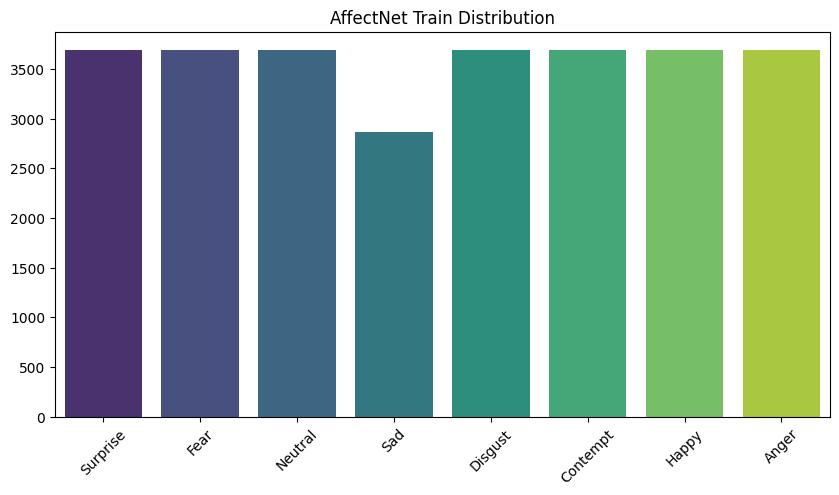

In [ ]:
print("Visualizing AffectNet Distribution...")
visualize_class_distribution(os.path.join(AFFECTNET_DIR, 'train'), "AffectNet Train Distribution")

Affectnet Samples


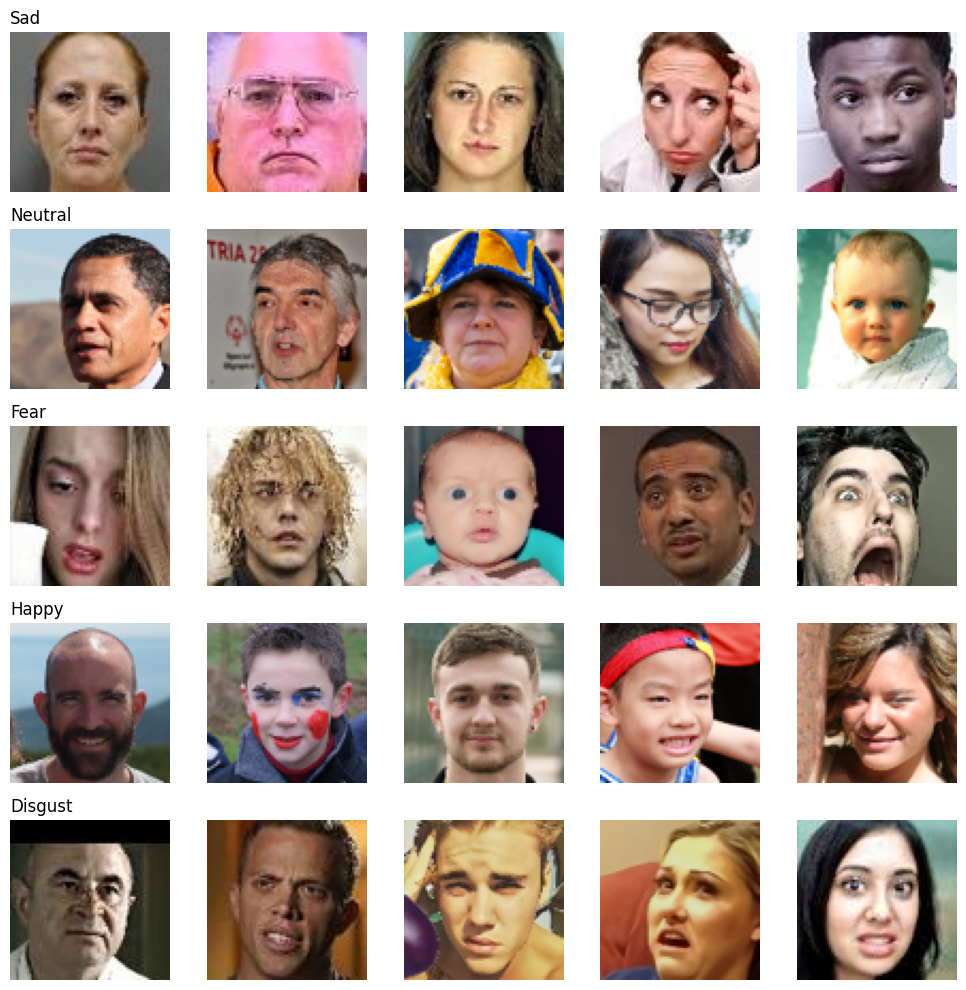

In [12]:
print('Affectnet Samples')
show_sample_images(os.path.join(AFFECTNET_DIR, 'train'))

In [ ]:
affectnet_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(8),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_ds_aff = datasets.ImageFolder(os.path.join(AFFECTNET_DIR, 'train'), affectnet_transforms['train'])
val_ds_aff = datasets.ImageFolder(os.path.join(AFFECTNET_DIR, 'val'), affectnet_transforms['val'])
loaders_aff = {
    'train': DataLoader(train_ds_aff, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_ds_aff, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}


STARTING PHASE 1: AffectNet Training (8 Classes)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 209MB/s]


Computing class weights for balanced training...
Class weights: tensor([0.9721, 0.9721, 0.9721, 0.9721, 0.9721, 0.9721, 1.2512, 0.9721],
       device='cuda:0')
Epoch 1/15
----------
train Loss: 1.3631 Acc: 0.5708
val Loss: 1.1947 Acc: 0.6493

Epoch 2/15
----------
train Loss: 1.1585 Acc: 0.6812
val Loss: 1.1309 Acc: 0.6898

Epoch 3/15
----------
train Loss: 1.0800 Acc: 0.7234
val Loss: 1.0896 Acc: 0.7076

Epoch 4/15
----------
train Loss: 1.0169 Acc: 0.7561
val Loss: 1.0785 Acc: 0.7218

Epoch 5/15
----------
train Loss: 0.9545 Acc: 0.7860
val Loss: 1.0521 Acc: 0.7435

DETAILED EVALUATION AT EPOCH 5

[Epoch 5] Validation Accuracy: 0.7435

Per-Class Accuracy:
  Anger: 72.26%
  Contempt: 76.06%
  Disgust: 66.31%
  Fear: 59.91%
  Happy: 93.93%
  Neutral: 91.55%
  Sad: 70.49%
  Surprise: 64.03%

Top Confusion Patterns:
  Fear → Surprise: 18.4% (170 samples)
  Disgust → Anger: 15.2% (140 samples)
  Sad → Anger: 13.9% (120 samples)


Epoch 6/15
----------
train Loss: 0.8964 Acc: 0.8125
val L

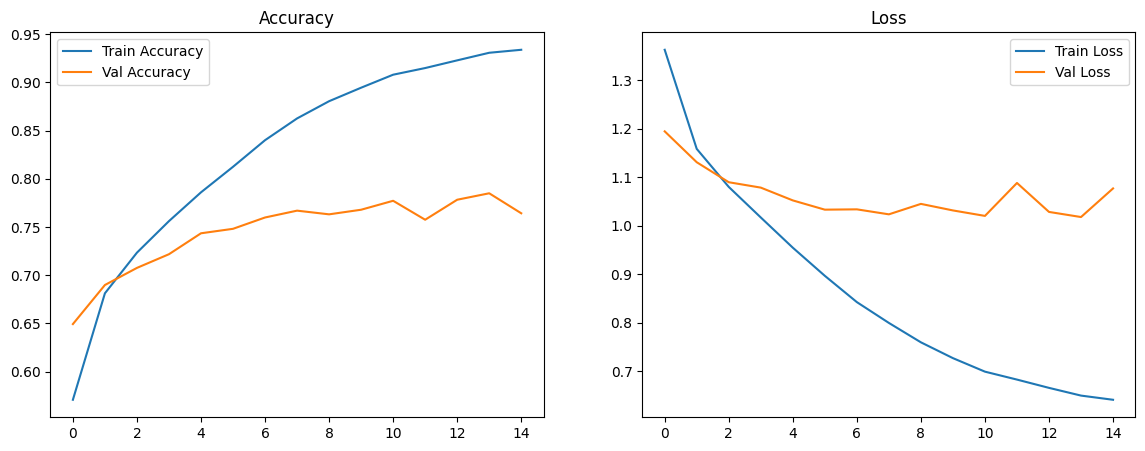

In [ ]:
print("\nSTARTING PHASE 1: AffectNet Training (8 Classes)")
model = ResNet34(num_classes=8).to(device)

print("Computing class weights for balanced training...")
class_weights_aff = compute_class_weights(train_ds_aff)
print(f"Class weights: {class_weights_aff}")

criterion = nn.CrossEntropyLoss(weight=class_weights_aff, label_smoothing=0.1)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

model, history_p1 = train_model(model, loaders_aff, criterion, optimizer, scheduler=scheduler,
                                 num_epochs=15, class_names=AFFECTNET_CLASSES, eval_frequency=5)
plot_training_history(history_p1)


Visualizing FER2013 Distribution...


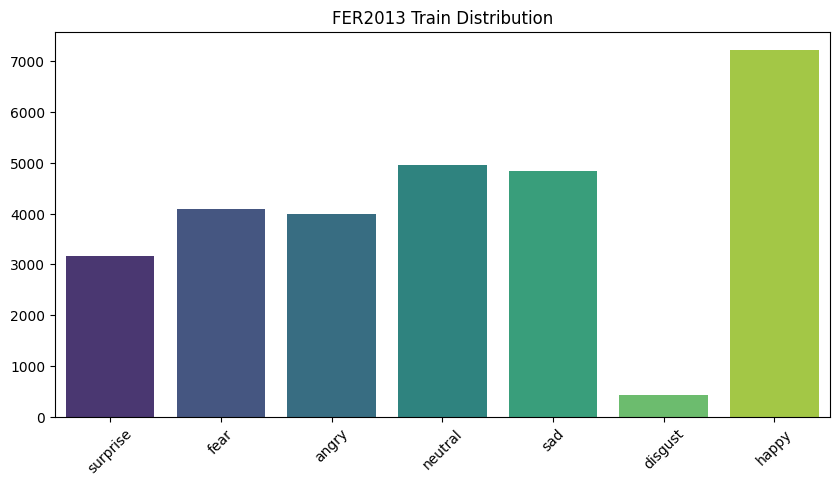

In [9]:
print("\nVisualizing FER2013 Distribution...")
visualize_class_distribution(FER_TRAIN_DIR, "FER2013 Train Distribution")

FER2013 Samples


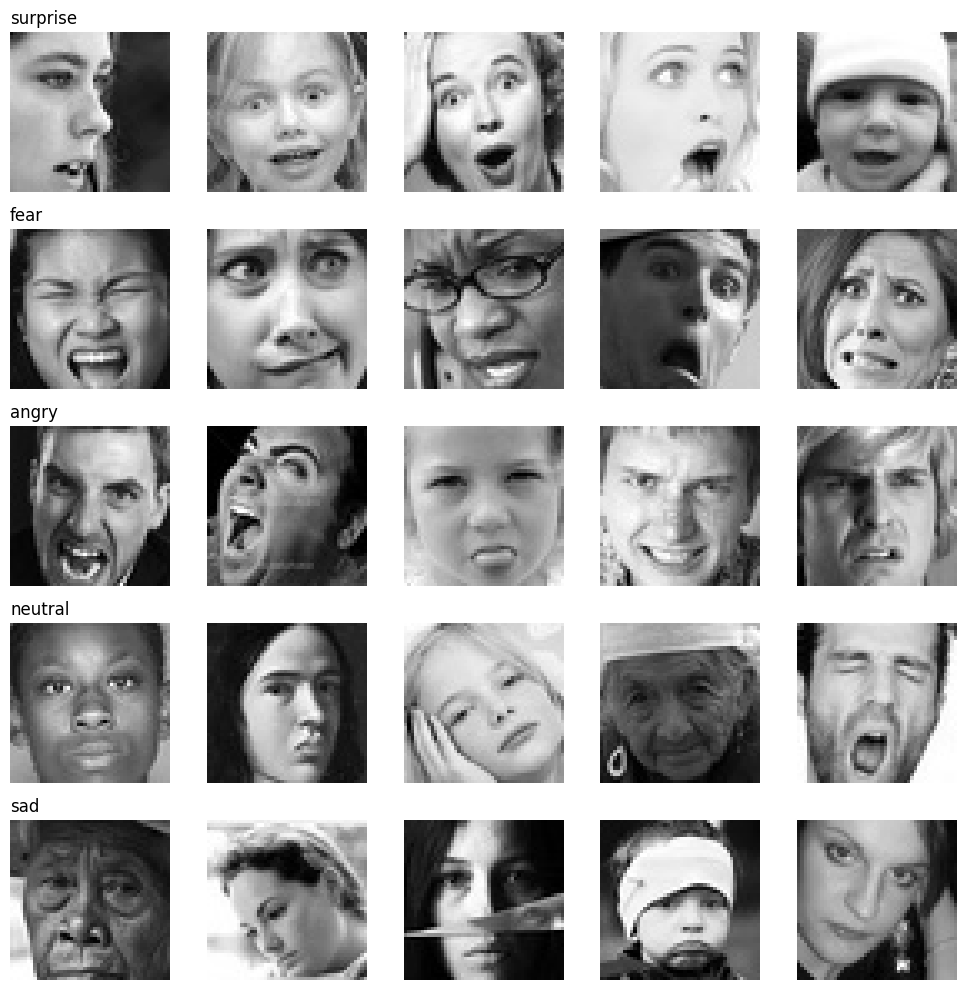

In [13]:
print('FER2013 Samples')
show_sample_images(FER_TRAIN_DIR)

In [ ]:
fer_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(12),
        transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),
        transforms.ColorJitter(brightness=0.25, contrast=0.25),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.15, scale=(0.02, 0.12))
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_ds_fer = datasets.ImageFolder(FER_TRAIN_DIR, fer_transforms['train'])
test_ds_fer = datasets.ImageFolder(FER_TEST_DIR, fer_transforms['val'])
loaders_fer = {
    'train': DataLoader(train_ds_fer, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(test_ds_fer, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}


Visualizing Data Augmentation Effects


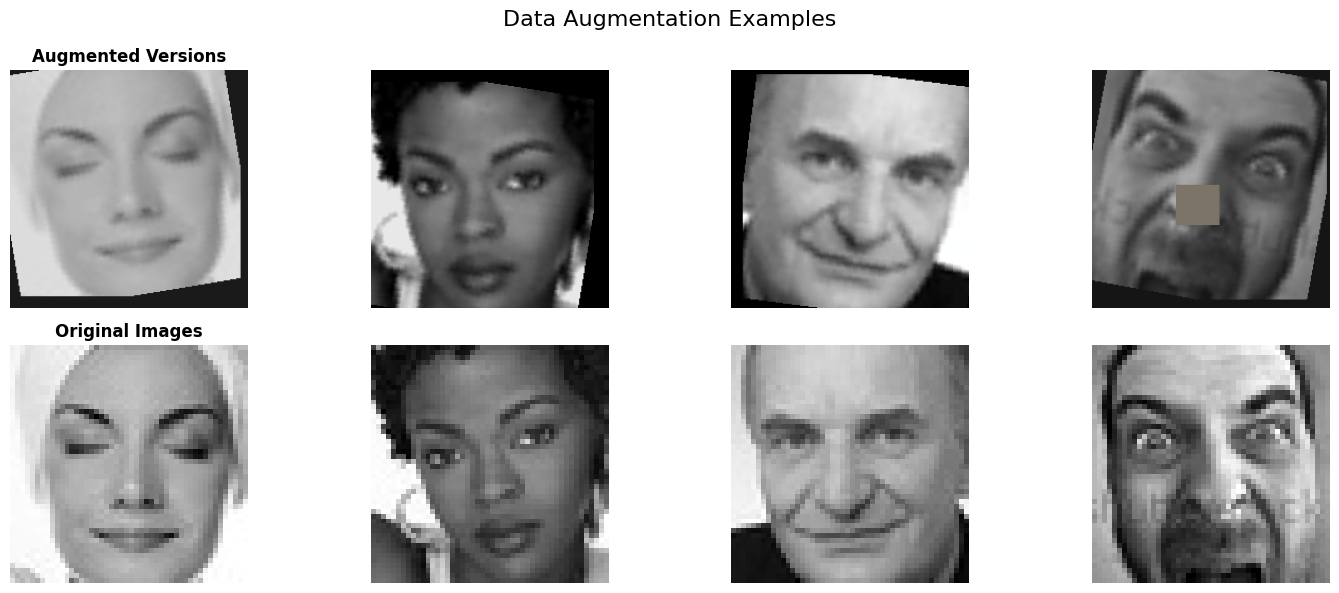

In [ ]:
print("\nVisualizing Data Augmentation Effects")
visualize_augmentations(train_ds_fer, num_samples=4)

In [ ]:
print("\nADAPTING MODEL FOR FER2013 (8 -> 7 Classes)")
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 7)
)
model = model.to(device)

print("Computing class weights for FER2013...")
class_weights_fer = compute_class_weights(train_ds_fer)
print(f"Class weights: {class_weights_fer}")

criterion = nn.CrossEntropyLoss(weight=class_weights_fer, label_smoothing=0.1)

optimizer_ft = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},
    {'params': model.spatial_attention.parameters(), 'lr': 5e-5},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.5, patience=3)


ADAPTING MODEL FOR FER2013 (8 -> 7 Classes)
Computing class weights for FER2013...
Class weights: tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8260, 0.8491, 1.2934],
       device='cuda:0')



STARTING PHASE 2: FER2013 Fine-Tuning
Epoch 1/12
----------
train Loss: 1.7395 Acc: 0.4758
val Loss: 1.7040 Acc: 0.5733

Epoch 2/12
----------
train Loss: 1.6115 Acc: 0.5656
val Loss: 1.6654 Acc: 0.6032

Epoch 3/12
----------
train Loss: 1.5538 Acc: 0.5983
val Loss: 1.6280 Acc: 0.6195

DETAILED EVALUATION AT EPOCH 3

[Epoch 3] Validation Accuracy: 0.6195

Per-Class Accuracy:
  Anger: 54.91%
  Disgust: 73.87%
  Fear: 21.09%
  Happy: 81.57%
  Neutral: 63.02%
  Sad: 57.42%
  Surprise: 82.19%

Top Confusion Patterns:
  Fear → Sad: 29.7% (304 samples)
  Neutral → Sad: 19.9% (245 samples)
  Sad → Neutral: 19.5% (243 samples)


Epoch 4/12
----------
train Loss: 1.5149 Acc: 0.6150
val Loss: 1.6009 Acc: 0.6358

Epoch 5/12
----------
train Loss: 1.4923 Acc: 0.6296
val Loss: 1.6119 Acc: 0.6278

Epoch 6/12
----------
train Loss: 1.4646 Acc: 0.6424
val Loss: 1.5875 Acc: 0.6449

DETAILED EVALUATION AT EPOCH 6

[Epoch 6] Validation Accuracy: 0.6449

Per-Class Accuracy:
  Anger: 55.43%
  Disgust: 78.

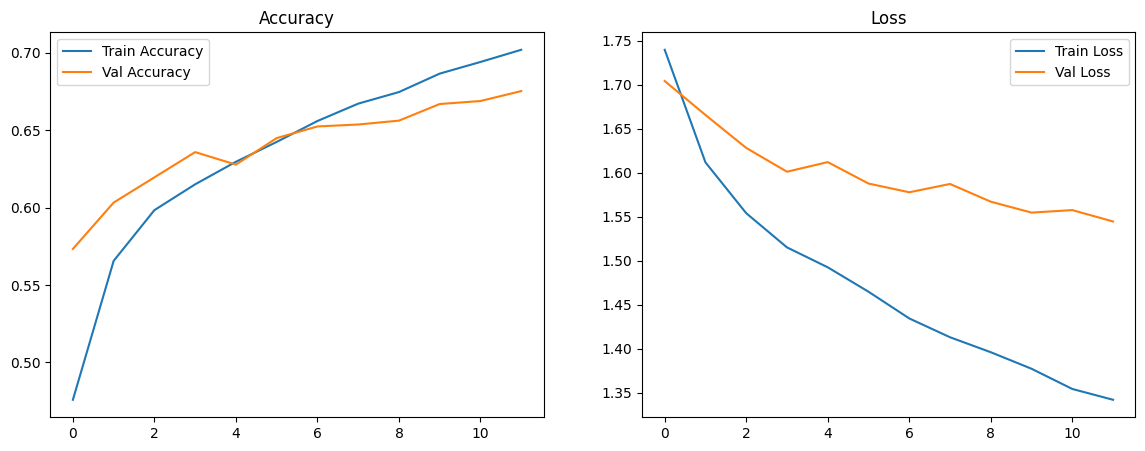

In [ ]:
print("\nSTARTING PHASE 2: FER2013 Fine-Tuning")
model, history_p2 = train_model(model, loaders_fer, criterion, optimizer_ft, scheduler=scheduler_ft,
                                 num_epochs=12, class_names=FER_CLASSES, eval_frequency=3)
plot_training_history(history_p2)

In [ ]:
print("\nFinal Evaluation on FER2013 Test Set")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in loaders_fer['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=FER_CLASSES))


Final Evaluation on FER2013 Test Set
              precision    recall  f1-score   support

       Anger       0.59      0.62      0.61       958
     Disgust       0.51      0.73      0.60       111
        Fear       0.56      0.43      0.48      1024
       Happy       0.89      0.85      0.87      1774
     Neutral       0.62      0.68      0.65      1233
         Sad       0.55      0.57      0.56      1247
    Surprise       0.76      0.80      0.78       831

    accuracy                           0.68      7178
   macro avg       0.64      0.67      0.65      7178
weighted avg       0.68      0.68      0.67      7178




Confusion Matrix


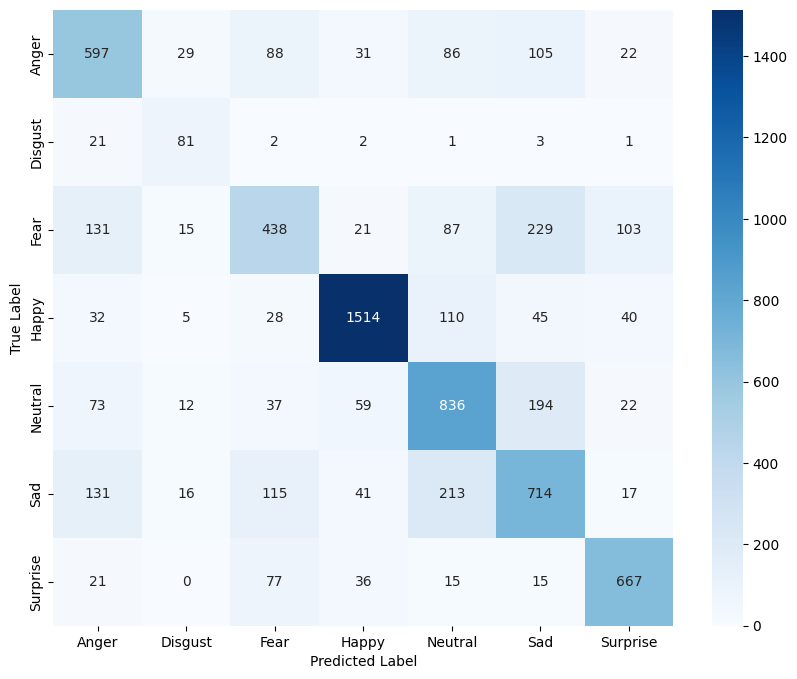

In [ ]:
print("\nConfusion Matrix")
plot_confusion_matrix(all_labels, all_preds, FER_CLASSES)


Misclassification Heatmap


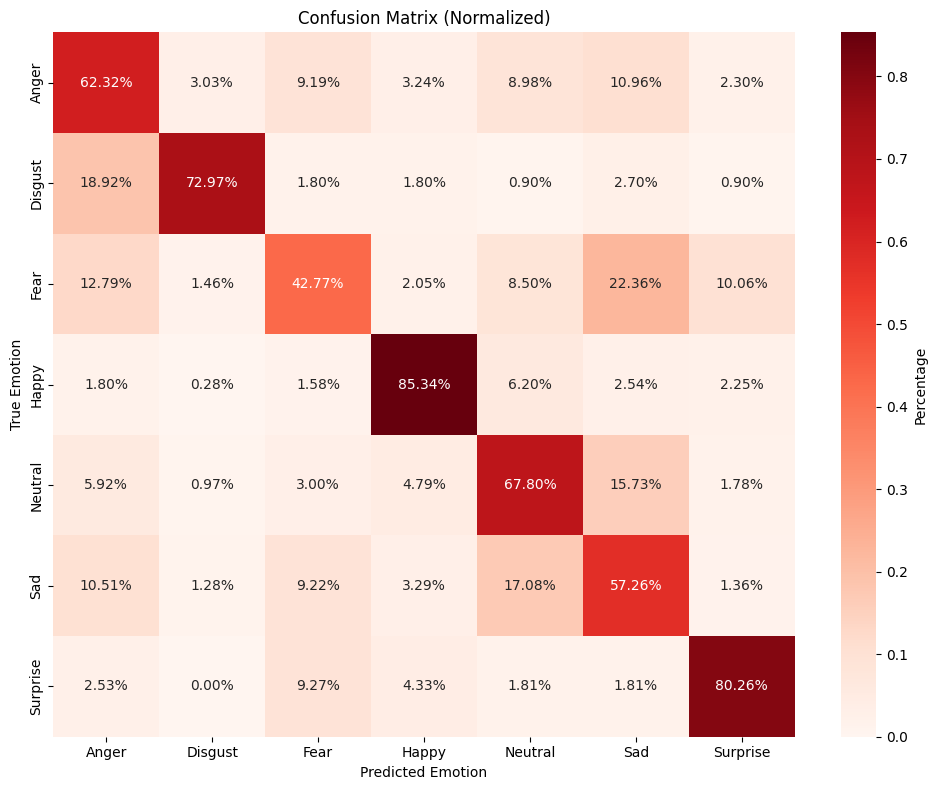

In [ ]:
print("\nMisclassification Heatmap")
plot_misclassification_heatmap(all_labels, all_preds, FER_CLASSES)


Per-Class Accuracy Analysis


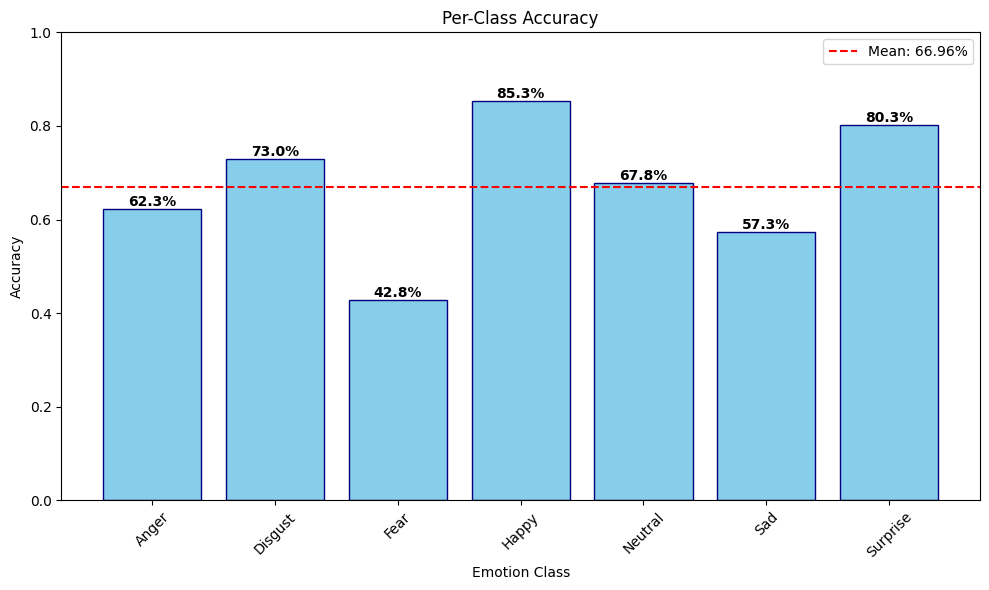

In [ ]:
print("\nPer-Class Accuracy Analysis")
plot_per_class_accuracy(all_labels, all_preds, FER_CLASSES)


Detailed Metrics Comparison


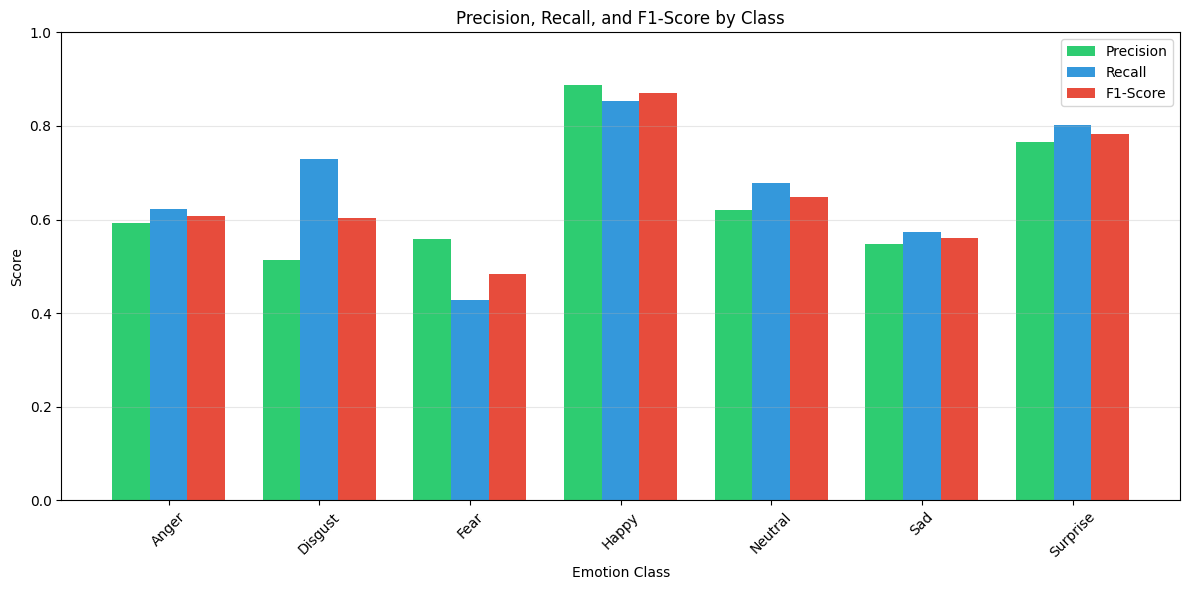

In [ ]:
print("\nDetailed Metrics Comparison")
compare_metrics(all_labels, all_preds, FER_CLASSES)


Examples of Misclassified Images


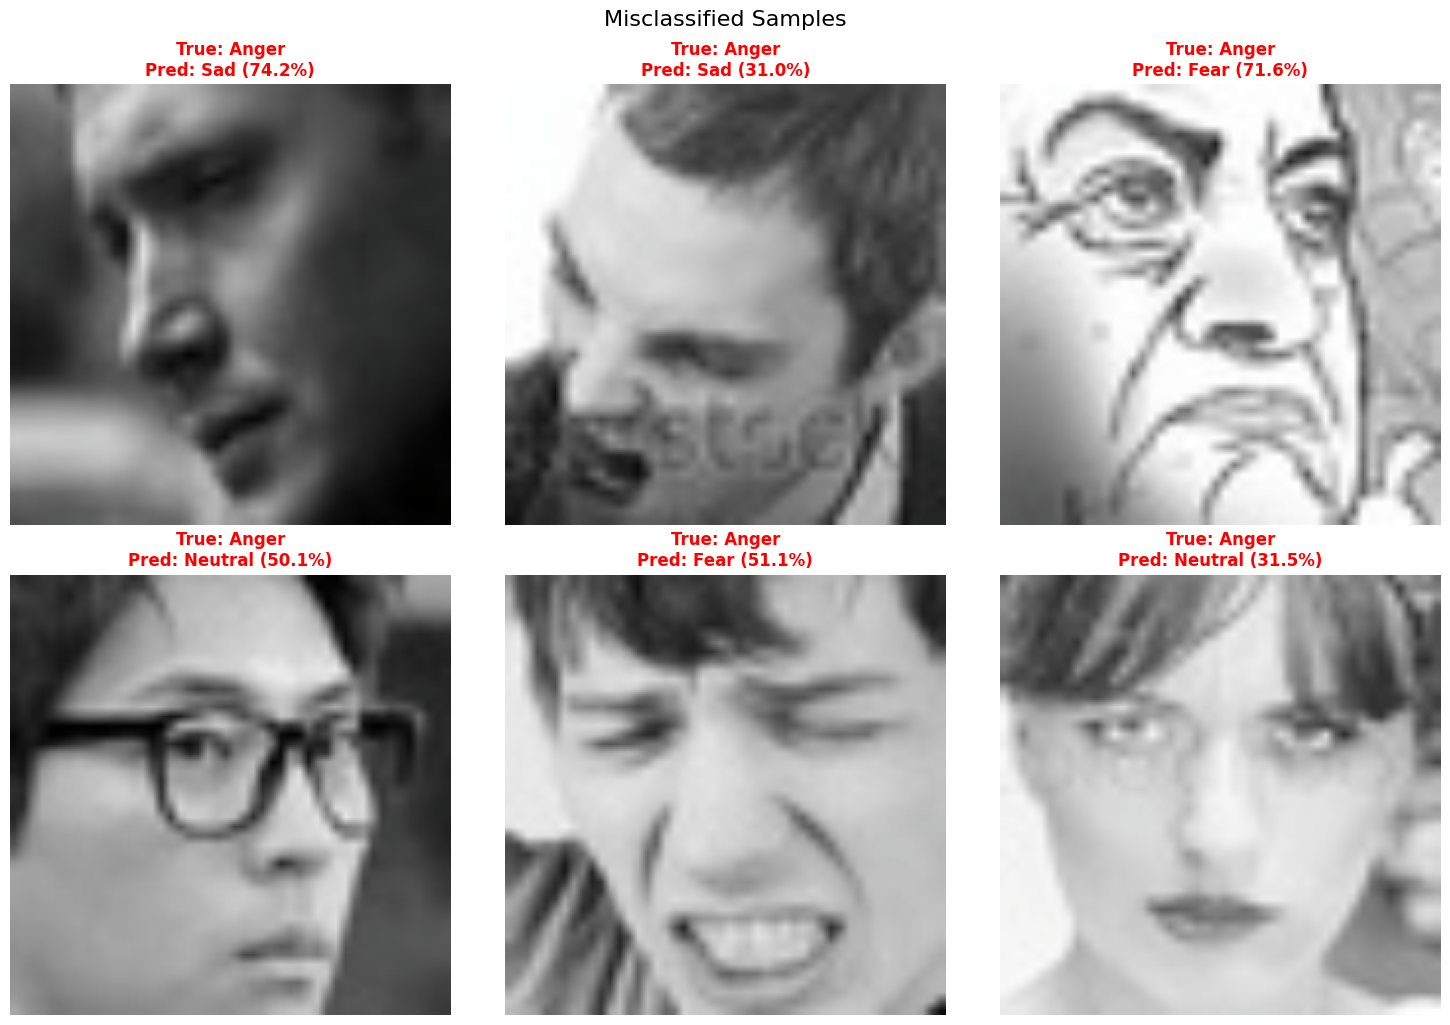

In [ ]:
print("\nExamples of Misclassified Images")
show_misclassified_samples(model, loaders_fer['val'], FER_CLASSES, num_samples=6)

In [ ]:
print("\nStatistical Analysis of Confusion Patterns")

def analyze_confusion_significance(y_true, y_pred, classes):
    from scipy.stats import chi2_contingency

    cm = confusion_matrix(y_true, y_pred)

    chi2, p_value, dof, expected = chi2_contingency(cm)

    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"P-value: {p_value:.4e}")
    print(f"Degrees of freedom: {dof}")

    if p_value < 0.05:
        print("Confusion patterns are statistically significant (p < 0.05)")
    else:
        print("Confusion patterns are not statistically significant")

    print("\n--- Analyzing High-Confusion Pairs ---")
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    problematic_pairs = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            if i != j and cm_normalized[i, j] > 0.15:
                problematic_pairs.append((
                    classes[i],
                    classes[j],
                    cm_normalized[i, j],
                    cm[i, j]
                ))

    if problematic_pairs:
        print("\nHigh Confusion Pairs (>15%):")
        for true_cls, pred_cls, rate, count in sorted(problematic_pairs, key=lambda x: x[2], reverse=True):
            print(f"  {true_cls:10s} → {pred_cls:10s}: {rate:6.1%} ({count:3d} samples)")
    else:
        print("No high-confusion pairs found!")

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("\n--- Classes Needing Improvement (<50% accuracy) ---")
    for i, (cls, acc) in enumerate(zip(classes, per_class_acc)):
        if acc < 0.5:
            print(f"  {cls}: {acc:.1%} accuracy")
            misclass = cm_normalized[i, :]
            top_confusions = np.argsort(misclass)[::-1][1:4]
            print(", ".join([f"{classes[j]} ({misclass[j]:.1%})" for j in top_confusions if misclass[j] > 0.05]))

analyze_confusion_significance(all_labels, all_preds, FER_CLASSES)


Statistical Analysis of Confusion Patterns
Chi-square statistic: 16557.93
P-value: 0.0000e+00
Degrees of freedom: 36
Confusion patterns are statistically significant (p < 0.05)

--- Analyzing High-Confusion Pairs ---

High Confusion Pairs (>15%):
  Fear       → Sad       :  22.4% (229 samples)
  Disgust    → Anger     :  18.9% ( 21 samples)
  Sad        → Neutral   :  17.1% (213 samples)
  Neutral    → Sad       :  15.7% (194 samples)

--- Classes Needing Improvement (<50% accuracy) ---
  Fear: 42.8% accuracy
    Most confused with: Sad (22.4%), Anger (12.8%), Surprise (10.1%)


In [ ]:
def predict_single_image(image_path, model, transform, class_names):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Could not open image. Error: {e}")
        return

    input_tensor = transform(image).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        score, predicted_idx = torch.max(outputs, 1)

    predicted_label = class_names[predicted_idx.item()]
    confidence = probabilities[0][predicted_idx.item()].item() * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%", color='green', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("\nConfidence Scores:")
    for i, class_name in enumerate(class_names):
        prob = probabilities[0][i].item() * 100
        print(f"{class_name}: {prob:.2f}%")

    return predicted_label, confidence


Testing Single Image Prediction (Random Sample)


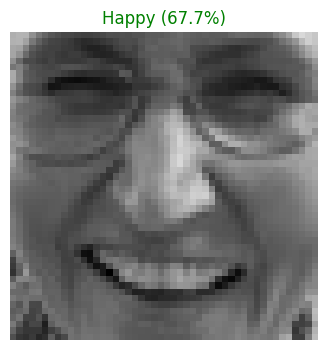

In [ ]:
print("\nTesting Single Image Prediction (Random Sample)")
rand_class = random.choice(os.listdir(FER_TEST_DIR))
rand_img = random.choice(os.listdir(os.path.join(FER_TEST_DIR, rand_class)))
img_path = os.path.join(FER_TEST_DIR, rand_class, rand_img)
predict_single_image(img_path, model, fer_transforms['val'], FER_CLASSES)

In [ ]:
import gdown

file_id = '1vFgY_imWBWRqh_ovXZc0M0uZsxdzTiDz'
output_path = 'downloaded_image.jpg'

url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output_path, quiet=False)

print(f"\nImage downloaded successfully to: {output_path}")

Downloading...
From: https://drive.google.com/uc?id=1vFgY_imWBWRqh_ovXZc0M0uZsxdzTiDz
To: /kaggle/working/downloaded_image.jpg
100%|██████████| 8.26k/8.26k [00:00<00:00, 10.8MB/s]


Image downloaded successfully to: downloaded_image.jpg


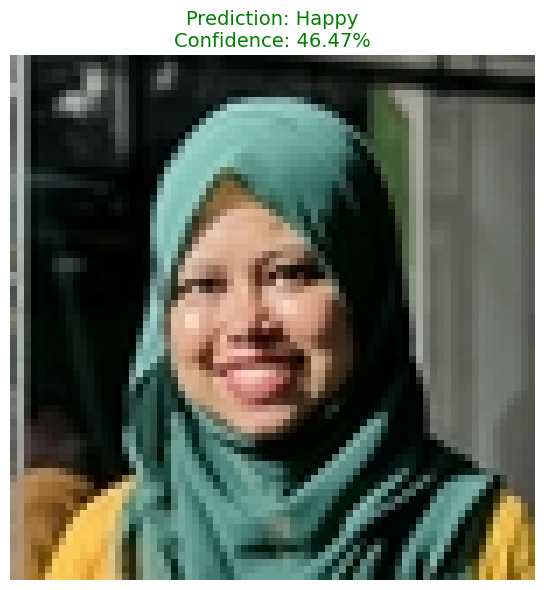


Confidence Scores:
Anger: 1.05%
Disgust: 17.69%
Fear: 4.46%
Happy: 46.47%
Neutral: 11.28%
Sad: 6.40%
Surprise: 12.65%


('Happy', 46.46513760089874)

In [ ]:
image_path = 'downloaded_image.jpg'

predict_single_image(image_path, model, fer_transforms['val'], FER_CLASSES)